# Table of Contents

1. [Setup](#setup)
2. [EDA](#eda)
3. [Basic XGBoost Model](#basic_model)
    1. [Imputing Missing Values](#imputing)
    2. [Basic Model Tuning](#basic_tuning)
    3. [Basic Predictions for Submission](#basic_submission)
4. [Data Cleaning & Feature Engineering](#data_fe)
    1. [Data Cleaning](#data_cleaning)
    2. [Feature Engineering](#feature_engineering)
    3. [Model After Feature Engineering](#model_after_fe)
5. [Parameter Tuning](#parameter_tuning)
    1. [Bayesian Optimization](#bayesian)
    2. [Model After Tuning](#tuned_model)
6. [Feature Importance & Data Transformation](#transformation)
    1. [Model After FE, Tuning, and Transformations](#final_model)
7. [Further Improvements](#improvements)

# Setup <a name="setup"></a>

Loading necessary packages, setting display options, and loading train/test data.

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
from scipy.stats import skew, norm
import statsmodels.api as sm
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBRegressor
import shap

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# EDA <a name="eda"></a>

Getting a general overview of the dataset, i.e., shape, data types, distribution of predictor variable (`SalePrice`), and simple variable correlations. Much more work could be done here, but I defer to the many other Kaggle notebooks that focus primarily on EDA for further insights.

In [3]:
# train_df.describe().transpose()

In [4]:
# print(train_df.dtypes)

In [5]:
print(train_df.shape)
print(test_df.shape)
train_df.head()

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


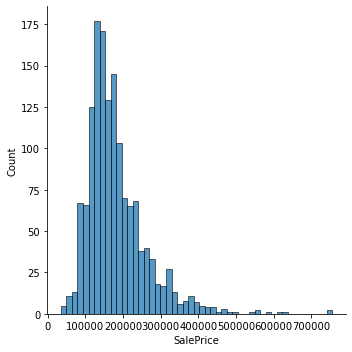

In [6]:
sns.displot(train_df["SalePrice"])

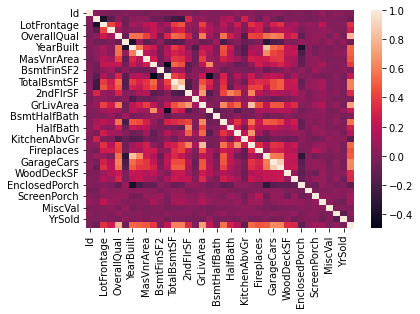

In [7]:
corrMatrix = train_df.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

In [8]:
# train_df.LandContour.value_counts()

# Basic XGBoost Model <a name="basic_model"></a>

## Imputing Missing Values <a name="imputing"></a>

The `SimpleImputer` replaces missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value. The code below is largely sourced from [Dan Becker](https://www.kaggle.com/code/dansbecker/xgboost)'s Kaggle notebook.

The following chunk splits the training set using a 25% test size. Since this is the model that will serve as the basis for further XGBoost models, only numeric variables are included.

In [9]:
train_df = train_df.dropna(axis=0, subset=["SalePrice"])
y = train_df.SalePrice
X = train_df.drop(["SalePrice", "Id"], axis=1).select_dtypes(exclude=["object"])  
print(X.columns)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

imputer = SimpleImputer()
train_X = imputer.fit_transform(train_X)
test_X = imputer.transform(test_X)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


Build and fit the XGBoost model.

In [10]:
xgb_model = XGBRegressor()
xgb_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Evaluate the XGBoost model and make predictions. The predictions are evaluated using mean absolute error, which is found using the following equation, where `n` is number of samples, x<sub>i</sub> is the prediction, and x is the true value. The MAE below represents the predictions from the _untuned_ XGBoost model, which can be used as a baseline to compare with further models.

![](https://www.statisticshowto.com/wp-content/uploads/2016/10/MAE.png)

In [11]:
predictions = xgb_model.predict(test_X)
print("MAE: " + str(round(mean_absolute_error(predictions, test_y))))

MAE: 17506


## Basic Model Tuning <a name="basic_tuning"></a>

**n_estimators** specifies the number of modeling cycles. With higher number of iterations comes greater potential for overfitting.

**early_stopping_rounds** specifies that the model should stop iterating when the validation score stops improving, even if the max number of modeling cycles has not been reached. It is possible to set a high n_estimators and use early_stopping_rounds to determine the optimal time to stop iterating. Randomness can causes a single round where validation scores don't improve, therefore a value greater than 1 should be used. early_stopping_rounds = 5 is reasonable and stops the model after 5 straight rounds of deteriorating validation scores.

**learning_rate** is the shrinkage at every step. Generally, smaller learning rates (and large number of estimators) yield more accuracy at the expense of longer training times.

The following model uses `n_estimators=1000`, `early_stopping_rounds=5`, `learning_rate=0.05`

In [12]:
xgb_model = XGBRegressor(n_estimators=1000,
                         early_stopping_rounds=5,
                         learning_rate=0.05)

xgb_model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [13]:
predictions = xgb_model.predict(test_X)
print("MAE : " + str(round(mean_absolute_error(predictions, test_y))))

MAE : 15761


## Basic Predictions for Submission <a name="basic_submission"></a>

Using the basic XGBoost model for an initial submission results in a RMSE value of **0.14384**, which achieves the rank 1746 out of 3949 (56th percentile) total submissions at the time of submission.

In [14]:
test_ids = test_df["Id"]
test_df_for_prediction = test_df.drop(["Id"], axis=1).select_dtypes(exclude=["object"])  

test_predictions = xgb_model.predict(test_df_for_prediction)

submission = pd.DataFrame({"Id": test_ids, "SalePrice": test_predictions})

# if no matching files, write to csv, if there are matching files, print statement
if not glob.glob("submission_v1.csv"):
    submission.to_csv("submission_v1.csv", index = False)
else:
    print("File Already Exists.")

File Already Exists.


# Data Cleaning & Feature Engineering <a name="data_fe"></a>

## Data Cleaning <a name="data_cleaning"></a>

The previous model only used numeric columns and an imputer to fill in missing values. The following section will further investigate the data and identify improved sets of variables. To do this, the training and test data are combined to apply the same manipulations.

In [15]:
train_ids = train_df["Id"]
train_saleprice = train_df["SalePrice"]
test_ids = test_df["Id"]

train_num_cols = train_df.drop(["Id", "SalePrice", "MoSold"], axis = 1).select_dtypes("int64", "float64").columns

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data = all_data.drop(["Id", "SalePrice"], axis = 1)

First, we investigate missing values. Dropping data columns with too many missing values will likely improve model performance rather than imputing values.

In [16]:
def missing_val_summary(df):
    missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False).to_frame("count")
    missing["perc"] = round(missing["count"] / len(df), 2)
    missing["dtype"] = df[missing.index].dtypes
    return missing

missing_val_summary(all_data)

,count,perc,dtype
PoolQC,2909,1.00,object
MiscFeature,2814,0.96,object
Alley,2721,0.93,object
Fence,2348,0.80,object
FireplaceQu,1420,0.49,object
LotFrontage,486,0.17,float64
GarageFinish,159,0.05,object
GarageQual,159,0.05,object
GarageCond,159,0.05,object
GarageYrBlt,159,0.05,float64


Based on these results, we drop the `PoolQC`, `MiscFeature`, `Alley`, `Fence`, and `FireplaceQu` variables. The remaining NA values for numeric variables will be imputed as before. The NA values for categorical variables will be filled with the most common value after encoding steps in the next section.

In [17]:
all_data = all_data.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])

Categorical variables were not included in the basic model. First `MSSubClass` is transformed into a categorical variable, since it represents numerical codes for building class. `MoSold`, standing for month sold, is also transformed.

In [18]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)

Then, categoricals that do not have meaningful distributions (as indicated by the frequencies of different categories) may improve model performance if dropped.

In [19]:
cat_cols = all_data.select_dtypes("object").columns
cat_freq = pd.DataFrame(columns = ['most_freq', 'second_freq'], index = cat_cols)

for i, col in enumerate(cat_cols):
    count = all_data[col].value_counts()
    count_perc = round(count / len(all_data), 3)
    cat_freq.iloc[i, 0] = count_perc[0]
    cat_freq.iloc[i, 1] = count_perc[1]
    
cat_freq.sort_values(by = 'most_freq', ascending = False).query("most_freq > 0.75")

,most_freq,second_freq
Utilities,0.999,0.0
Street,0.996,0.004
Condition2,0.99,0.004
RoofMatl,0.985,0.008
Heating,0.985,0.009
LandSlope,0.952,0.043
CentralAir,0.933,0.067
Functional,0.931,0.024
Electrical,0.915,0.064
GarageCond,0.909,0.025


Categorical variables represented by a single value with over 95% frequency are dropped, including `Utilities`, `Street`, `Condition2`, `Heating`, `RoofMatl`, and `LandSlope`.

In [20]:
all_data = all_data.drop(['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'LandSlope'], axis=1)

## Feature Engineering <a name="feature_engineering"></a>

In order to include categorical variables, they need to be transformed into a useable, numeric data type for the XGBoost model. 

First, inspecting the variables may reveal ordinal variables that can be transformed into numeric values. The variables that could clearly be transformed are `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `CentralAir`, `KitchenQual`, `Functional`, `GarageFinish`, `GarageQual`, `GarageCond`, `HeatingQC`, and `PavedDrive`. Some variables give meaning to NA (e.g., for BsmtQual it indicates "no basement"). 

In [21]:
def cat_map(col):
    if col in ["ExterQual", "ExterCond", "KitchenQual", "HeatingQC"]: 
        mapping = {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
    if col in ["BsmtQual", "BsmtCond", "GarageQual", "GarageCond"]:
        mapping = {np.NaN: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    if col in ["BsmtFinType1", "BsmtFinType2"]:
        mapping = {np.NaN: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    if col == "BsmtExposure": 
        mapping = {np.NaN: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
    if col == "CentralAir":
        mapping = {"N": 0, "Y": 1}
    if col == "Functional":
        mapping = {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7}
    if col == "GarageFinish":
        mapping = {np.NaN: 0, "Unf": 1, "RFn": 2, "Fin": 3}
    if col == "PavedDrive":
        mapping = {"N": 0, "P": 1, "Y": 2}
        
    return mapping

ordinal_cols = ["ExterQual", "ExterCond", "KitchenQual", "HeatingQC", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2",
                "BsmtExposure", "CentralAir", "Functional", "GarageFinish", "GarageCond", "GarageQual", "PavedDrive"]

for col in ordinal_cols:
    all_data = all_data.replace({col: cat_map(col)})

In [22]:
missing_val_summary(all_data)

,count,perc,dtype
LotFrontage,486,0.17,float64
GarageYrBlt,159,0.05,float64
GarageType,157,0.05,object
MasVnrType,24,0.01,object
MasVnrArea,23,0.01,float64
MSZoning,4,0.00,object
BsmtHalfBath,2,0.00,float64
Functional,2,0.00,float64
BsmtFullBath,2,0.00,float64
GarageArea,1,0.00,float64


The remaining columns with missing values are replaced smartly. For example:

- `LotFrontage` is replaced by the median value for the same neighborhood.

- `GarageType` and `MasVnrType` are replaced by "None".

- `GarageYrBlt`, `GarageCars`,  and `MasVnrArea` are replaced by 0.

- `Electrical` is replaced by the most common category, since there is only one missing value.



In [23]:
def plot_top_n_neighborhood_lotfrontage(n):
    top_neighborhoods = train_df["Neighborhood"].value_counts().sort_values(ascending=False).nlargest(n)
    top_neighborhoods_df = train_df.query("Neighborhood in @top_neighborhoods.index")
    plot = top_neighborhoods_df["LotFrontage"].hist(by = top_neighborhoods_df["Neighborhood"], figsize=(16, 9))
    return plot

In [24]:
# Filling in NA values with 0
for col in ["MasVnrArea", "GarageYrBlt", "GarageCars", "GarageArea", "BsmtFullBath", "BsmtHalfBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]:
    all_data[col] = all_data[col].fillna(0)

# Filling in NA values with None
for col in ["GarageType", "MasVnrType"]:
    all_data[col] = all_data[col].fillna("None")
    
# Fill in NA values with most frequent (mode)
for col in ["Electrical", "SaleType", "Exterior1st", "Exterior2nd", "KitchenQual", "Functional"]:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
# Fill data based on groups
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data["MSZoning"] = all_data.groupby("MSSubClass")["MSZoning"].transform(lambda x: x.fillna(x.mode()[0]))

Next, the remaining categorical variables need to be encoded. Here, I refer to [Mikhail Sukhanov](https://www.kaggle.com/code/mikhailsukhanov55/house-prices-data-cleaning-feature-engineering)'s notebook, which target encodes variables only where the standard deviation of the encoded categorical feature is greater than the standard deviation of the target feature. Otherwise, one hot encoding is used.

In [25]:
num_cols = [i for i in all_data.columns if all_data[i].dtype in ['int64', 'float64']]
cat_cols = [i for i in all_data.columns if all_data[i].dtype == 'object']

def target_encoding(target_feature, df):
    if len(cat_cols) == 0:
        return 'All features are encoded'
    target_std = df[target_feature].std()
    cols = []
    for col in cat_cols:
        encoded_std = df.groupby(col)[target_feature].mean().std()
        if target_std < encoded_std:
            df[col] = df.groupby(col)[target_feature].transform('mean')
            cat_cols.remove(col)
            cols.append(col)
            te_cols.append(col)

print(len(cat_cols))
print(len(num_cols))
print(len(all_data.columns))

19
49
68


The target encoding process resulted in 5 remaining categorical columns that need to be one hot encoded.

In [26]:
te_cols = []
for col in num_cols:
    target_encoding(col, all_data)
    
print(len(cat_cols))
print(len(te_cols))
print(te_cols)

8
11
['LotShape', 'Electrical', 'MSZoning', 'Foundation', 'Exterior1st', 'SaleCondition', 'HouseStyle', 'MSSubClass', 'BldgType', 'GarageType', 'RoofStyle']


Here we one hot encode the remaining variables and drop the original categorical columns. This results in a training dataset that has 144 columns. One hot encoding often results in wide dataframes.

In [27]:
for col in cat_cols:
    dummies = pd.get_dummies(all_data[col], prefix=col).astype('int64')
    all_data = pd.concat([all_data, dummies], axis=1)

all_data = all_data.drop(cat_cols, axis=1)
print(all_data.shape)

(2919, 144)


## Model After Feature Engineering <a name="model_after_fe"></a>

First, the concatenated dataframe can be separated into the original train and test dataframes.

In [28]:
ntrain = len(train_df)

train_df_fe = all_data.loc[:ntrain-1].copy()
train_df_fe["SalePrice"] = train_saleprice

test_df_fe = all_data.loc[ntrain:]

print(train_df_fe.shape)
print(test_df_fe.shape)

(1460, 145)
(1459, 144)


After the feature engineering and data cleaning steps, the Mean Absolute Error (MAE) has decreased from the previous model, which only had basic tuning changes, from 15,761 to 15,086.

In [29]:
y = train_df_fe.SalePrice
X = train_df_fe.drop(["SalePrice"], axis=1)  

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

xgb_model = XGBRegressor(n_estimators=3000,
                         early_stopping_rounds=5,
                         eta=0.05)

xgb_model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose = False)

predictions = xgb_model.predict(test_X)
print("MAE : " + str(round(mean_absolute_error(predictions, test_y))))

MAE : 15086


Adding the feature engineering steps resulted in marginally improved results, scoring an RMSE of **0.14864**, which ranks 1498 out of 3954 submissions (62nd percentile).

In [30]:
test_df_for_prediction = test_df_fe

test_predictions = xgb_model.predict(test_df_for_prediction)

submission = pd.DataFrame({"Id": test_ids, "SalePrice": test_predictions})

# if no matching files, write to csv, if there are matching files, print statement
if not glob.glob("submission_v2.csv"):
    submission.to_csv("submission_v2.csv", index = False)
else:
    print("File Already Exists.")

File Already Exists.


# Parameter Tuning <a name="parameter_tuning"></a>

The previous model did not incorporate any cohesive method to determine it's hyperparameters. The following section focuses only on tuning these parameters. [A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook) by Prashant Banerjee was used for reference.

The three types of parameters that need to be set are general parameters, booster parameters, and task parameters.

The main general parameter is `booster`, which chooses the booster used by the model (one of gbtree [default], gblinear, or dart). There are many booster parameters that have varying degrees of impact on model performance. Learning task parameters define the optimization objective and metric to be calculated at each step to evaluate the model.

The following uses Bayesian Optimization through the HYPEROPT library. Bayesian Optimization takes into account past evaluations when choosing the optimal hyperparameter sets, which should yield better performance than using a random or grid search technique.

First, the domain space, or set of input values to be searched, is defined.

## Bayesian Optimization <a name="bayesian"></a>

In [31]:
space = {
    'eta': hp.uniform('eta', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 1),
    'max_depth': hp.quniform("max_depth", 3, 10, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.4, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
    'alpha' : hp.uniform('alpha', 0, 1),
    'n_estimators': hp.quniform('n_estimators', 2000, 3000, 100),
    'early_stopping_rounds': hp.quniform('early_stopping_rounds', 5, 15, 1),
    'seed': 1
}

Next an objective function is created, which returns the validation error of the XGBoost model to be minimized with respect to the possible hyperparameter sets in the space above.

In [32]:
def objective(space):
    
    xgb_model = XGBRegressor(
        eta = space['eta'],
        gamma = space['gamma'],
        max_depth = int(space['max_depth']), 
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        subsample = space['subsample'],
        reg_lambda = space['reg_lambda'],
        alpha = space['alpha'],
        n_estimators = int(space['n_estimators']), 
        early_stopping_rounds = int(space['early_stopping_rounds'])
    )
    
    xgb_model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose = False)

    predictions = xgb_model.predict(test_X)
    accuracy = mean_absolute_error(predictions, test_y)
    print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

The space and objective function are used in the optimization algorithm below, which aims to identify the parameter set with the lowest MAE.

In [33]:
%%time

trials = Trials()

best_hyperparams = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

print(best_hyperparams)

SCORE:                                                                                                                 
14741.166791523972                                                                                                     
SCORE:                                                                                                                 
14802.054312928081                                                                                                     
SCORE:                                                                                                                 
15060.302001284246                                                                                                     
SCORE:                                                                                                                 
14768.820612157535                                                                                                     
SCORE:                                  

The best parameter loss is 13,453, which is lower than the previous model without tuning. Certain parameters need to be converted back to integer type.

In [34]:
int_params = ['max_depth', 'early_stopping_rounds', 'min_child_weight', 'n_estimators']
for param in int_params:
    best_hyperparams[param] = best_hyperparams[param].astype(int)

best_hyperparams

{'alpha': 0.1378913095014144,
 'colsample_bytree': 0.7640126319415066,
 'early_stopping_rounds': 7,
 'eta': 0.023994158824230154,
 'gamma': 0.36431827129851024,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 2900,
 'reg_lambda': 0.5317162853487578,
 'subsample': 0.7317567613348605}

## Model After Parameter Tuning <a name="tuned_model"></a>

In [35]:
y = train_df_fe.SalePrice
X = train_df_fe.drop(["SalePrice"], axis=1)  

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

xgb_model = XGBRegressor(**best_hyperparams)

xgb_model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose = False)

predictions = xgb_model.predict(test_X)
print("MAE: " + str(round(mean_absolute_error(predictions, test_y))))

MAE: 13582


The submitted predictions based on this model resulted in an RMSE of 0.13095, which ranked 1044 out of 3944 submissions (74th percentile).

In [36]:
test_df_for_prediction = test_df_fe

test_predictions = xgb_model.predict(test_df_for_prediction)

submission = pd.DataFrame({"Id": test_ids, "SalePrice": test_predictions})

# if no matching files, write to csv, if there are matching files, print statement
if not glob.glob("submission_v3.csv"):
    submission.to_csv("submission_v3.csv", index = False)
else:
    print("File Already Exists.")

File Already Exists.


# Feature Importance & Data Transformation <a name="transformation"></a>

It may be useful to create derived variables from the dataset. First, shap values can give an impression of important variables in the dataset. There are a few important variables that all relate to square footage or living area. 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


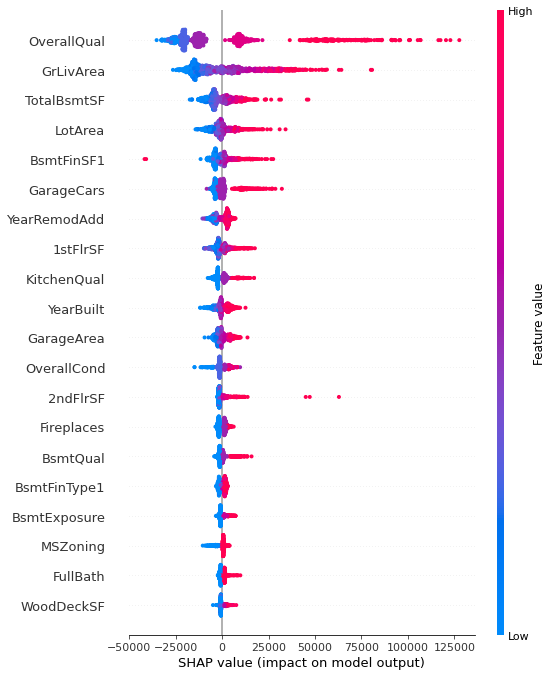

In [37]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

Based on the variable importance results, certain derived variables that are more intuitively connected to purchase prices can be created, such as total living square footage and total number of bathrooms.

In [38]:
all_data["SqFtPerRoom"] = all_data["GrLivArea"] / (all_data["TotRmsAbvGrd"] + all_data["FullBath"] + all_data["HalfBath"] + all_data["KitchenAbvGr"])
all_data['TotalQual'] = all_data['OverallQual'] + all_data['OverallCond']
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data["LivingSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]

Additionally, variables with high skew are manipulated using a log transformation. This includes the predictor variable.

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


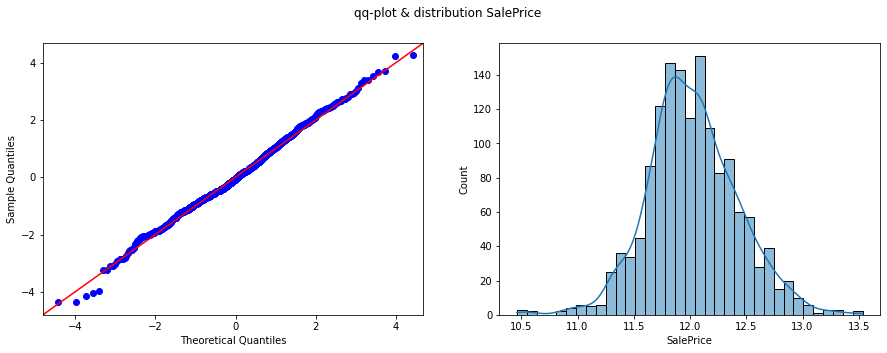

In [39]:
# Identify skewed variables
skewed_features = all_data[train_num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 1]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
for i in skew_index:
    all_data[i] = np.log1p(all_data[i])
    
# SalePrice after transformation
train_saleprice_log = np.log1p(train_saleprice)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice")

sm.qqplot(train_saleprice_log, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.histplot(train_saleprice_log, kde=True, ax=ax[1])
plt.show()

## Model After FE, Tuning, and Transformations <a name="final_model"></a>

The last model combines all data manipulations and model tuning. The same tuning steps are used on the updated dataset.

In [40]:
ntrain = len(train_df)

train_df_fe = all_data.loc[:ntrain-1].copy()
train_df_fe["SalePrice"] = train_saleprice_log

test_df_fe = all_data.loc[ntrain:]

print(train_df_fe.shape)
print(test_df_fe.shape)

y = train_df_fe.SalePrice
X = train_df_fe.drop(["SalePrice"], axis=1)  

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

(1460, 149)
(1459, 148)


Since the data has been transformed, the scores are not comparable to the previous model. To accurately compare, the exponential of the predictions can be compared with the exponential test_y values.

In [42]:
%%time

trials = Trials()

best_hyperparams = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

print(best_hyperparams)

SCORE:                                                                                                                 
0.09630801473756036                                                                                                    
SCORE:                                                                                                                 
0.09056024695308611                                                                                                    
SCORE:                                                                                                                 
0.09055506613862123                                                                                                    
SCORE:                                                                                                                 
0.09813290271715162                                                                                                    
SCORE:                                  

In [49]:
int_params = ['max_depth', 'early_stopping_rounds', 'min_child_weight', 'n_estimators']
for param in int_params:
    best_hyperparams[param] = best_hyperparams[param].astype(int)

best_hyperparams

{'alpha': 0.10758286304593359,
 'colsample_bytree': 0.433146361566116,
 'early_stopping_rounds': 7,
 'eta': 0.010165810043733639,
 'gamma': 0.02643358866893947,
 'max_depth': 10,
 'min_child_weight': 4,
 'n_estimators': 2800,
 'reg_lambda': 0.8018284129760868,
 'subsample': 0.7079119771052093}

In [60]:
y = train_df_fe.SalePrice
X = train_df_fe.drop(["SalePrice"], axis=1)  

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

xgb_model = XGBRegressor(**best_hyperparams)

xgb_model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose = False)

predictions = xgb_model.predict(test_X)
print("MAE: " + str(mean_absolute_error(predictions, test_y)))

MAE: 0.08160580076835582


The final submission achieved a RMSE of **0.12713**, which ranks 806 out of 3945 submissions (80th percentile) at the time of completion. 

In [59]:
test_df_for_prediction = test_df_fe

test_predictions = xgb_model.predict(test_df_for_prediction)

submission = pd.DataFrame({"Id": test_ids, "SalePrice": np.exp(test_predictions)})

# if no matching files, write to csv, if there are matching files, print statement
if not glob.glob("submission_v4.csv"):
    submission.to_csv("submission_v4.csv", index = False)
else:
    print("File Already Exists.")

# Further Improvements <a name="improvements"></a>

Some of the top notebooks on Kaggle use stacked regressions or ensemble methods to achieve better performance. Others conduct more extensive feature engineering and manipulation. These are likely the main two areas of improvement. 